In [1]:
def iou_2d(box1, box2):
    box1 = box1.flatten()
    box2 = box2.flatten()
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
    area_sum = abs(area1) + abs(area2)
    
    #計算重疊方形座標
    x1 = max(box1[0], box2[0]) # left
    y1 = max(box1[1], box2[1]) # top
    x2 = min(box1[2], box2[2]) # right
    y2 = min(box1[3], box2[3]) # btm

    if x1 >= x2 or y1 >= y2:
        return 0
    else:
        inter_area = abs((x2-x1)*(y2-y1))
    return inter_area/(area_sum-inter_area)

In [2]:
class DetectedObject(object):
    def __init__(self, line):
        self.line = line
        self.class_ = None
        self.box2d = None
        self.dims = None
        self.locs = None
        self.rys = None
        self.id = None
        self.frames = list()
        self.crops = list()
        self.lines = list()
        self.set_info(line)
        
    def set_info(self, line):
        self.lines.append(line)
        elements = line.split()
        for j in range(1, len(elements)):
            elements[j] = float(elements[j])
        top_left = [int(round(elements[4])), int(round(elements[5]))]
        btm_right = [int(round(elements[6])), int(round(elements[7]))]
        self.box2d = np.array([top_left, btm_right])
        self.class_ = elements[0]
        self.alphas = [elements[3]]
        self.dims = [[elements[8], elements[9], elements[10]]]
        self.locs = [[elements[11], elements[12], elements[13]]]
        self.rys = [elements[14]]
        if len(elements) == 16:
            self.id = int(elements[15])
    
    def update_info(self, obj):
        self.box2d = obj.box2d
        self.alphas += obj.alphas
        self.dims += obj.dims
        self.locs += obj.locs
        self.rys += obj.rys
        self.lines.append(obj.line)
        
    def record_frames(self, frame_id):
        self.frames.append(frame_id)

In [ ]:
import glob
import numpy as np
import cv2
import os
cam_to_img = np.array([
        [ 1.418667e+03, 0.000000e+00, 6.4e+02,0],
        [ 0.000000e+00, 1.418667e+03, 3.6e+02,0],
        [ 0.000000e+00, 0.000000e+00, 1.000000e+00,0]])

#1532~1632 tracking
#40-60 tracking
images = glob.glob('Elan_3d_box/image_2/*.png')
renew_labels = glob.glob('Elan_3d_box/renew_label/*.txt')

trainset = [x.strip() for x in open('Elan_3d_box/ImageSets/train.txt').readlines()]
print(len(trainset))
print(trainset[-1])
# train 0-1605.txt
# val 1606-txt
os.makedirs('Elan_3d_box/renew_label_obj', exist_ok=True)
def tracking_obj_by_labels(label, start, end, WRITE_FILE=False, folder='renew_label', new_folder='renew_label_obj'):
    tracking_dict = dict()
    for idx in range(start, end):
        #print(f'======{idx}====={label[idx]}====')
        lines = [x.strip() for x in open(label[idx]).readlines()]
        new_lines = [line for line in lines]
        img = cv2.cvtColor(cv2.imread(images[idx]), cv2.COLOR_BGR2RGB)
        objects = [DetectedObject(line) for line in lines]
        if len(tracking_dict.keys()) == 0:
            for id_, obj in enumerate(objects):
                
                tracking_dict[id_] = obj
                tracking_dict[id_].record_frames(idx)
                new_lines[id_] += f' {id_}'
                #top_left, btm_right = obj.box2d
                #crop = img[top_left[1]:btm_right[1]+1, top_left[0]:btm_right[0]+1]
                #tracking_dict[id_].crops.append(crop)
        else:
            for obj_idx, obj in enumerate(objects):
                #print(obj.class_)
                now_box2d = obj.box2d
                match = False
                #top_left, btm_right = obj.box2d
                #crop = img[top_left[1]:btm_right[1]+1, top_left[0]:btm_right[0]+1]
                for key in tracking_dict.keys():
                    last_box2d = tracking_dict[key].box2d
                    iou_value = iou_2d(now_box2d, last_box2d)
                    last_frame = tracking_dict[key].frames[-1]
                    if iou_value > 0.6 and idx - last_frame < 5:
                        #print(f'MATCHED:{iou_value:.2f}')
                        match = True
                        tracking_dict[key].update_info(obj)
                        tracking_dict[key].record_frames(idx)
                        #tracking_dict[key].crops.append(crop)
                        new_lines[obj_idx] += f' {key}'
                        break
                if not match: #new obj
                    new_id = len(tracking_dict.keys())
                    tracking_dict[new_id] = obj
                    tracking_dict[new_id].record_frames(idx)
                    #tracking_dict[new_id].crops.append(crop)
                    new_lines[obj_idx] += f' {key}'
        if WRITE_FILE:
            with open(label[idx].replace('renew_label', 'renew_label_obj'), 'w') as f:
                for line in new_lines:
                    f.writelines(line + '\n')
    return tracking_dict

In [65]:
tracking_dict = tracking_obj_by_labels(renew_labels, 0, len(renew_labels), WRITE_FILE=True)

### 0719 DOING frame consistency

In [6]:
from library.ron_utils import *
from torch_lib.ClassAverages import *

def get_object_label(objects, bin_num=4):
    ELAN_averages = ClassAverages(average_file='renew_ELAN_class_averages.txt')
    label = dict()
    Heading_class = list()
    Residual = list()
    Dim_delta = list()
    TrackID = list()
    for obj in objects:
        heading_class, residual = angle2class(obj.alphas[0], bin_num)
        dim_delta = np.array(obj.dims[0]) - ELAN_averages.get_item(obj.class_)
        obj_id = obj.id
        Heading_class.append(heading_class)
        Residual.append(residual)
        Dim_delta.append(dim_delta)
        TrackID.append(obj_id)
    label['bin'] = torch.tensor(Heading_class)
    label['residual'] = torch.tensor(Residual)
    label['dim_delta'] = torch.tensor(np.array(Dim_delta))
    label['track_id'] = TrackID
    return label

def id_compare(now_id, last_id):
    now_id_list = list()
    last_id_list = list()
    for idx, id_ in enumerate(now_id):
        try:
            find_idx = last_id.index(id_)
        except:
            find_idx = -1

        if find_idx != -1:
            now_id_list.append(idx)
            last_id_list.append(find_idx)
    return now_id_list, last_id_list

In [7]:
from torchvision.models import vgg
from torch_lib.Model_heading_bin import *
from torchvision import transforms
import torch.nn.functional as F
import time

#device = 'cpu'
device = 'cuda'
trainset = [x.strip() for x in open('Elan_3d_box/ImageSets/train.txt').readlines()]
bin_num = 4
angle_per_class = 2*np.pi/float(bin_num)
batch_size = 16

my_vgg = vgg.vgg19_bn(weights='DEFAULT')
model = Model(features=my_vgg.features, bins=bin_num).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
process = transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize([224,224]),
                            #transforms.Normalize(mean=[0.596, 0.612, 0.587], std=[0.256, 0.254, 0.257])
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                            ])
start = time.time()
for epoch in range(5):
    batch_count = 0
    count = 0
    passes = 0
    for id_ in trainset:
        img = cv2.cvtColor(cv2.imread(f'Elan_3d_box/image_2/{id_}.png'), cv2.COLOR_BGR2RGB)
        label = f'Elan_3d_box/renew_label_obj/{id_}.txt'
        lines = [x.strip() for x in open(label).readlines()]
        obj_count = len(lines)
        batch_count += len(lines)

        if obj_count == 0:
            continue
        objects = [DetectedObject(line) for line in lines]
        crops = [process(img[obj.box2d[0][1]:obj.box2d[1][1]+1 ,obj.box2d[0][0]:obj.box2d[1][0]+1]) for obj in objects]
        crops = torch.stack(crops).to(device)

        gt_labels = get_object_label(objects, bin_num)
        gt_bin = gt_labels['bin'].to(device)
        gt_residual = gt_labels['residual'].to(device)
        gt_dim_delta = gt_labels['dim_delta'].to(device)
        now_id = gt_labels['track_id']

        [reg_residual, reg_bin, reg_dim_delta] = model(crops)

        bin_loss = F.cross_entropy(reg_bin, gt_bin, reduction='mean')
        residual_loss, _ = compute_residual_loss(reg_residual, gt_bin, gt_residual, device)
        dim_loss = F.l1_loss(reg_dim_delta, gt_dim_delta, reduction='mean')

        if count == 0:
            consist_loss = torch.tensor(0.0)
            count +=1
        else:
            now_id_list, last_id_list = id_compare(now_id, last_id)
            #print(now_id, last_id)
            if len(now_id_list) != 0:
                reg_dim_delta_id = reg_dim_delta[now_id_list]
                last_dim_delta_id = last_dim_delta[last_id_list]
                consist_loss = F.l1_loss(reg_dim_delta_id, last_dim_delta_id, reduction='mean')*len(now_id_list)/len(now_id)
            else:
                consist_loss = torch.tensor(0.0)
            #print(consist_loss)

        angle_loss = bin_loss + residual_loss
        loss = 0.6 * dim_loss + angle_loss + consist_loss

        last_bin = torch.clone(reg_bin).detach()
        last_residual = torch.clone(reg_residual).detach()
        last_dim_delta = torch.clone(reg_dim_delta).detach()
        last_id = now_id
        #https://zhuanlan.zhihu.com/p/65002487
        loss /= obj_count
        loss.backward()  # 计算梯度
        if(batch_count//batch_size)== 1:
            #print(batch_count)
            batch_count = 0 
            optimizer.step()        
            optimizer.zero_grad()
            passes += 1
        
        if passes % 100 == 0:
            print("--- epoch %s | passes %s --- [loss: %.3f],[bin_loss:%.3f],[residual_loss:%.3f],[dim_loss:%.3f],[consist_loss:%.3f]" \
                    %(epoch+1, passes, loss.item(), bin_loss.item(), residual_loss.item(), dim_loss.item(), consist_loss.item()))
            
    if (epoch+1) % 2 == 0:
            name = f'elan_consist_{epoch+1}.pkl'
            print("====================")
            print ("Done with epoch %s!" % (epoch+1))
            print ("Saving weights as %s ..." % name)
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'bin': bin_num,
                    }, name)
            print("====================")
print(f'Elapsed time: {(time.time()-start)//60} min')
# 68/1591 是沒有consist_loss的

--- epoch 1 | passes 0 --- [loss: 0.818],[bin_loss:1.258],[residual_loss:0.189],[dim_loss:0.315],[consist_loss:0.000]
--- epoch 1 | passes 0 --- [loss: 0.838],[bin_loss:1.258],[residual_loss:0.166],[dim_loss:0.307],[consist_loss:0.068]
--- epoch 1 | passes 0 --- [loss: 0.828],[bin_loss:1.282],[residual_loss:0.176],[dim_loss:0.283],[consist_loss:0.028]
--- epoch 1 | passes 0 --- [loss: 0.884],[bin_loss:1.351],[residual_loss:0.218],[dim_loss:0.333],[consist_loss:0.000]
--- epoch 1 | passes 0 --- [loss: 0.897],[bin_loss:1.345],[residual_loss:0.231],[dim_loss:0.363],[consist_loss:0.000]
--- epoch 1 | passes 0 --- [loss: 0.825],[bin_loss:1.368],[residual_loss:0.176],[dim_loss:0.176],[consist_loss:0.000]
--- epoch 1 | passes 0 --- [loss: 1.549],[bin_loss:1.274],[residual_loss:0.199],[dim_loss:0.127],[consist_loss:0.000]
--- epoch 1 | passes 0 --- [loss: 0.821],[bin_loss:1.336],[residual_loss:0.190],[dim_loss:0.193],[consist_loss:0.000]
--- epoch 1 | passes 10 --- [loss: 0.691],[bin_loss:1.18

--- epoch 1 | passes 120 --- [loss: 0.334],[bin_loss:0.018],[residual_loss:0.056],[dim_loss:1.351],[consist_loss:0.117]
--- epoch 1 | passes 120 --- [loss: 0.335],[bin_loss:0.030],[residual_loss:0.095],[dim_loss:1.342],[consist_loss:0.072]
--- epoch 1 | passes 120 --- [loss: 0.330],[bin_loss:0.023],[residual_loss:0.102],[dim_loss:1.329],[consist_loss:0.066]
--- epoch 1 | passes 120 --- [loss: 0.363],[bin_loss:0.042],[residual_loss:0.102],[dim_loss:1.369],[consist_loss:0.123]
--- epoch 1 | passes 120 --- [loss: 0.192],[bin_loss:0.025],[residual_loss:0.049],[dim_loss:0.706],[consist_loss:0.078]
--- epoch 1 | passes 120 --- [loss: 0.199],[bin_loss:0.014],[residual_loss:0.056],[dim_loss:0.771],[consist_loss:0.064]
--- epoch 1 | passes 130 --- [loss: 0.189],[bin_loss:0.063],[residual_loss:0.092],[dim_loss:0.591],[consist_loss:0.058]
--- epoch 1 | passes 130 --- [loss: 0.327],[bin_loss:0.891],[residual_loss:0.075],[dim_loss:0.518],[consist_loss:0.032]
--- epoch 1 | passes 130 --- [loss: 0.45

--- epoch 1 | passes 230 --- [loss: 0.249],[bin_loss:0.052],[residual_loss:0.170],[dim_loss:0.741],[consist_loss:0.079]
--- epoch 1 | passes 230 --- [loss: 0.215],[bin_loss:0.018],[residual_loss:0.108],[dim_loss:0.773],[consist_loss:0.055]
--- epoch 1 | passes 230 --- [loss: 0.213],[bin_loss:0.030],[residual_loss:0.092],[dim_loss:0.784],[consist_loss:0.045]
--- epoch 1 | passes 240 --- [loss: 0.215],[bin_loss:0.059],[residual_loss:0.154],[dim_loss:0.945],[consist_loss:0.079]
--- epoch 1 | passes 240 --- [loss: 0.197],[bin_loss:0.076],[residual_loss:0.103],[dim_loss:0.945],[consist_loss:0.042]
--- epoch 1 | passes 240 --- [loss: 0.205],[bin_loss:0.070],[residual_loss:0.140],[dim_loss:0.963],[consist_loss:0.032]
--- epoch 1 | passes 240 --- [loss: 0.215],[bin_loss:0.083],[residual_loss:0.152],[dim_loss:0.952],[consist_loss:0.052]
--- epoch 1 | passes 250 --- [loss: 0.185],[bin_loss:0.087],[residual_loss:0.116],[dim_loss:1.108],[consist_loss:0.056]
--- epoch 1 | passes 250 --- [loss: 0.18

--- epoch 2 | passes 80 --- [loss: 0.123],[bin_loss:0.029],[residual_loss:0.089],[dim_loss:0.372],[consist_loss:0.026]
--- epoch 2 | passes 80 --- [loss: 0.113],[bin_loss:0.006],[residual_loss:0.049],[dim_loss:0.395],[consist_loss:0.045]
--- epoch 2 | passes 80 --- [loss: 0.116],[bin_loss:0.008],[residual_loss:0.061],[dim_loss:0.360],[consist_loss:0.064]
--- epoch 2 | passes 80 --- [loss: 0.103],[bin_loss:0.013],[residual_loss:0.036],[dim_loss:0.380],[consist_loss:0.032]
--- epoch 2 | passes 80 --- [loss: 0.477],[bin_loss:0.885],[residual_loss:0.103],[dim_loss:0.620],[consist_loss:0.069]
--- epoch 2 | passes 80 --- [loss: 0.043],[bin_loss:0.005],[residual_loss:0.029],[dim_loss:0.105],[consist_loss:0.032]
--- epoch 2 | passes 90 --- [loss: 0.607],[bin_loss:0.955],[residual_loss:0.112],[dim_loss:1.218],[consist_loss:0.022]
--- epoch 2 | passes 90 --- [loss: 0.172],[bin_loss:0.020],[residual_loss:0.078],[dim_loss:0.663],[consist_loss:0.019]
--- epoch 2 | passes 90 --- [loss: 0.178],[bin_l

--- epoch 2 | passes 200 --- [loss: 0.187],[bin_loss:0.306],[residual_loss:0.090],[dim_loss:0.779],[consist_loss:0.075]
--- epoch 2 | passes 200 --- [loss: 0.152],[bin_loss:0.046],[residual_loss:0.077],[dim_loss:0.663],[consist_loss:0.087]
--- epoch 2 | passes 210 --- [loss: 0.088],[bin_loss:0.068],[residual_loss:0.063],[dim_loss:0.215],[consist_loss:0.090]
--- epoch 2 | passes 210 --- [loss: 0.093],[bin_loss:0.054],[residual_loss:0.097],[dim_loss:0.245],[consist_loss:0.073]
--- epoch 2 | passes 210 --- [loss: 0.133],[bin_loss:0.313],[residual_loss:0.101],[dim_loss:0.327],[consist_loss:0.056]
--- epoch 2 | passes 210 --- [loss: 0.104],[bin_loss:0.060],[residual_loss:0.089],[dim_loss:0.248],[consist_loss:0.118]
--- epoch 2 | passes 220 --- [loss: 2.171],[bin_loss:1.486],[residual_loss:0.106],[dim_loss:0.822],[consist_loss:0.086]
--- epoch 2 | passes 220 --- [loss: 0.871],[bin_loss:1.150],[residual_loss:0.312],[dim_loss:0.469],[consist_loss:0.000]
--- epoch 2 | passes 220 --- [loss: 0.48

--- epoch 3 | passes 40 --- [loss: 0.072],[bin_loss:0.011],[residual_loss:0.016],[dim_loss:0.065],[consist_loss:0.077]
--- epoch 3 | passes 40 --- [loss: 0.050],[bin_loss:0.010],[residual_loss:0.038],[dim_loss:0.055],[consist_loss:0.069]
--- epoch 3 | passes 40 --- [loss: 0.060],[bin_loss:0.013],[residual_loss:0.080],[dim_loss:0.046],[consist_loss:0.059]
--- epoch 3 | passes 40 --- [loss: 0.060],[bin_loss:0.019],[residual_loss:0.072],[dim_loss:0.069],[consist_loss:0.048]
--- epoch 3 | passes 40 --- [loss: 0.152],[bin_loss:0.382],[residual_loss:0.120],[dim_loss:0.116],[consist_loss:0.036]
--- epoch 3 | passes 50 --- [loss: 0.279],[bin_loss:0.749],[residual_loss:0.033],[dim_loss:0.487],[consist_loss:0.040]
--- epoch 3 | passes 50 --- [loss: 0.066],[bin_loss:0.007],[residual_loss:0.041],[dim_loss:0.179],[consist_loss:0.044]
--- epoch 3 | passes 50 --- [loss: 0.053],[bin_loss:0.003],[residual_loss:0.025],[dim_loss:0.168],[consist_loss:0.031]
--- epoch 3 | passes 50 --- [loss: 0.057],[bin_l

--- epoch 3 | passes 170 --- [loss: 0.322],[bin_loss:0.503],[residual_loss:0.021],[dim_loss:0.639],[consist_loss:0.059]
--- epoch 3 | passes 170 --- [loss: 0.439],[bin_loss:0.699],[residual_loss:0.057],[dim_loss:1.611],[consist_loss:0.036]
--- epoch 3 | passes 170 --- [loss: 0.415],[bin_loss:0.609],[residual_loss:0.074],[dim_loss:1.545],[consist_loss:0.049]
--- epoch 3 | passes 170 --- [loss: 0.416],[bin_loss:0.408],[residual_loss:0.039],[dim_loss:1.231],[consist_loss:0.064]
--- epoch 3 | passes 170 --- [loss: 0.308],[bin_loss:0.015],[residual_loss:0.030],[dim_loss:0.703],[consist_loss:0.149]
--- epoch 3 | passes 180 --- [loss: 0.635],[bin_loss:0.061],[residual_loss:0.052],[dim_loss:1.833],[consist_loss:0.058]
--- epoch 3 | passes 180 --- [loss: 0.538],[bin_loss:0.022],[residual_loss:0.009],[dim_loss:0.787],[consist_loss:0.035]
--- epoch 3 | passes 180 --- [loss: 0.727],[bin_loss:0.705],[residual_loss:0.087],[dim_loss:1.023],[consist_loss:0.049]
--- epoch 3 | passes 180 --- [loss: 0.57

--- epoch 4 | passes 0 --- [loss: 0.232],[bin_loss:0.188],[residual_loss:0.119],[dim_loss:0.260],[consist_loss:0.000]
--- epoch 4 | passes 0 --- [loss: 0.239],[bin_loss:0.221],[residual_loss:0.164],[dim_loss:0.155],[consist_loss:0.000]
--- epoch 4 | passes 0 --- [loss: 0.329],[bin_loss:0.016],[residual_loss:0.234],[dim_loss:0.133],[consist_loss:0.000]
--- epoch 4 | passes 0 --- [loss: 0.150],[bin_loss:0.085],[residual_loss:0.061],[dim_loss:0.258],[consist_loss:0.000]
--- epoch 4 | passes 10 --- [loss: 0.096],[bin_loss:0.003],[residual_loss:0.045],[dim_loss:0.149],[consist_loss:0.054]
--- epoch 4 | passes 10 --- [loss: 0.074],[bin_loss:0.002],[residual_loss:0.040],[dim_loss:0.139],[consist_loss:0.023]
--- epoch 4 | passes 10 --- [loss: 0.101],[bin_loss:0.001],[residual_loss:0.065],[dim_loss:0.151],[consist_loss:0.045]
--- epoch 4 | passes 10 --- [loss: 0.073],[bin_loss:0.011],[residual_loss:0.030],[dim_loss:0.120],[consist_loss:0.033]
--- epoch 4 | passes 10 --- [loss: 0.088],[bin_loss:

--- epoch 4 | passes 130 --- [loss: 0.161],[bin_loss:0.016],[residual_loss:0.087],[dim_loss:0.368],[consist_loss:0.158]
--- epoch 4 | passes 130 --- [loss: 0.234],[bin_loss:0.489],[residual_loss:0.066],[dim_loss:0.495],[consist_loss:0.082]
--- epoch 4 | passes 130 --- [loss: 0.226],[bin_loss:0.373],[residual_loss:0.098],[dim_loss:0.629],[consist_loss:0.055]
--- epoch 4 | passes 130 --- [loss: 0.182],[bin_loss:0.054],[residual_loss:0.079],[dim_loss:0.630],[consist_loss:0.035]
--- epoch 4 | passes 130 --- [loss: 0.295],[bin_loss:0.410],[residual_loss:0.127],[dim_loss:0.975],[consist_loss:0.059]
--- epoch 4 | passes 140 --- [loss: 0.237],[bin_loss:0.347],[residual_loss:0.150],[dim_loss:0.612],[consist_loss:0.082]
--- epoch 4 | passes 140 --- [loss: 0.218],[bin_loss:0.032],[residual_loss:0.138],[dim_loss:0.637],[consist_loss:0.101]
--- epoch 4 | passes 140 --- [loss: 0.201],[bin_loss:0.045],[residual_loss:0.139],[dim_loss:0.610],[consist_loss:0.052]
--- epoch 4 | passes 140 --- [loss: 0.19

--- epoch 4 | passes 240 --- [loss: 0.166],[bin_loss:0.020],[residual_loss:0.059],[dim_loss:0.911],[consist_loss:0.039]
--- epoch 4 | passes 250 --- [loss: 0.168],[bin_loss:0.050],[residual_loss:0.052],[dim_loss:1.141],[consist_loss:0.051]
--- epoch 4 | passes 250 --- [loss: 0.159],[bin_loss:0.035],[residual_loss:0.027],[dim_loss:1.097],[consist_loss:0.073]
--- epoch 4 | passes 250 --- [loss: 0.165],[bin_loss:0.224],[residual_loss:0.084],[dim_loss:1.002],[consist_loss:0.081]
--- epoch 4 | passes 260 --- [loss: 0.181],[bin_loss:0.028],[residual_loss:0.029],[dim_loss:1.013],[consist_loss:0.059]
--- epoch 4 | passes 260 --- [loss: 0.195],[bin_loss:0.030],[residual_loss:0.065],[dim_loss:0.989],[consist_loss:0.090]
--- epoch 4 | passes 260 --- [loss: 0.195],[bin_loss:0.027],[residual_loss:0.045],[dim_loss:1.009],[consist_loss:0.105]
--- epoch 4 | passes 260 --- [loss: 0.182],[bin_loss:0.032],[residual_loss:0.043],[dim_loss:0.991],[consist_loss:0.057]
--- epoch 4 | passes 270 --- [loss: 0.11

--- epoch 5 | passes 90 --- [loss: 0.384],[bin_loss:0.399],[residual_loss:0.026],[dim_loss:1.133],[consist_loss:0.046]
--- epoch 5 | passes 90 --- [loss: 0.166],[bin_loss:0.008],[residual_loss:0.068],[dim_loss:0.625],[consist_loss:0.047]
--- epoch 5 | passes 90 --- [loss: 0.146],[bin_loss:0.002],[residual_loss:0.033],[dim_loss:0.612],[consist_loss:0.034]
--- epoch 5 | passes 90 --- [loss: 0.264],[bin_loss:0.004],[residual_loss:0.009],[dim_loss:0.751],[consist_loss:0.065]
--- epoch 5 | passes 90 --- [loss: 0.258],[bin_loss:0.003],[residual_loss:0.030],[dim_loss:0.748],[consist_loss:0.034]
--- epoch 5 | passes 90 --- [loss: 0.264],[bin_loss:0.013],[residual_loss:0.037],[dim_loss:0.750],[consist_loss:0.029]
--- epoch 5 | passes 90 --- [loss: 0.240],[bin_loss:0.007],[residual_loss:0.017],[dim_loss:0.727],[consist_loss:0.019]
--- epoch 5 | passes 90 --- [loss: 0.737],[bin_loss:0.000],[residual_loss:0.015],[dim_loss:1.111],[consist_loss:0.055]
--- epoch 5 | passes 100 --- [loss: 0.068],[bin_

--- epoch 5 | passes 210 --- [loss: 0.084],[bin_loss:0.017],[residual_loss:0.057],[dim_loss:0.228],[consist_loss:0.124]
--- epoch 5 | passes 220 --- [loss: 1.760],[bin_loss:0.869],[residual_loss:0.046],[dim_loss:0.909],[consist_loss:0.300]
--- epoch 5 | passes 220 --- [loss: 0.512],[bin_loss:0.527],[residual_loss:0.254],[dim_loss:0.407],[consist_loss:0.000]
--- epoch 5 | passes 220 --- [loss: 0.296],[bin_loss:0.018],[residual_loss:0.132],[dim_loss:0.244],[consist_loss:0.000]
--- epoch 5 | passes 220 --- [loss: 0.458],[bin_loss:0.009],[residual_loss:0.233],[dim_loss:0.359],[consist_loss:0.000]
--- epoch 5 | passes 220 --- [loss: 0.353],[bin_loss:0.002],[residual_loss:0.149],[dim_loss:0.337],[consist_loss:0.000]
--- epoch 5 | passes 220 --- [loss: 0.429],[bin_loss:0.001],[residual_loss:0.197],[dim_loss:0.384],[consist_loss:0.000]
--- epoch 5 | passes 220 --- [loss: 0.259],[bin_loss:0.000],[residual_loss:0.058],[dim_loss:0.335],[consist_loss:0.000]
--- epoch 5 | passes 220 --- [loss: 0.27

## EVAL TRAIN_VIDEO

In [107]:
from torchvision.models import vgg
from torch_lib.Model_heading_bin import *
from torchvision import transforms
import torch.nn.functional as F
import time

#device = 'cpu'
device = 'cuda'
trainset = [x.strip() for x in open('Elan_3d_box/ImageSets/train.txt').readlines()]
bin_num = 4
angle_per_class = 2*np.pi/float(bin_num)
batch_size = 16

my_vgg = vgg.vgg19_bn(weights='DEFAULT')
model = Model(features=my_vgg.features, bins=bin_num).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
process = transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize([224,224]),
                            #transforms.Normalize(mean=[0.596, 0.612, 0.587], std=[0.256, 0.254, 0.257])
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                            ])
model.train()
start = time.time()
for epoch in range(5):
    batch_count = 0
    count = 0
    passes = 0
    for id_ in trainset:
        img = cv2.cvtColor(cv2.imread(f'Elan_3d_box/image_2/{id_}.png'), cv2.COLOR_BGR2RGB)
        label = f'Elan_3d_box/renew_label_obj/{id_}.txt'
        lines = [x.strip() for x in open(label).readlines()]
        obj_count = len(lines)
        batch_count += len(lines)

        if obj_count == 0:
            continue
        objects = [DetectedObject(line) for line in lines]
        crops = [process(img[obj.box2d[0][1]:obj.box2d[1][1]+1 ,obj.box2d[0][0]:obj.box2d[1][0]+1]) for obj in objects]
        crops = torch.stack(crops).to(device)

        gt_labels = get_object_label(objects, bin_num)
        gt_bin = gt_labels['bin'].to(device)
        gt_residual = gt_labels['residual'].to(device)
        gt_dim_delta = gt_labels['dim_delta'].to(device)
        now_id = gt_labels['track_id']

        [reg_residual, reg_bin, reg_dim_delta] = model(crops)

        bin_loss = F.cross_entropy(reg_bin, gt_bin, reduction='mean')
        residual_loss, _ = compute_residual_loss(reg_residual, gt_bin, gt_residual, device)
        dim_loss = F.l1_loss(reg_dim_delta, gt_dim_delta, reduction='mean')

        if count == 0:
            consist_loss = torch.tensor(0.0)
            count +=1
        else:
            now_id_list, last_id_list = id_compare(now_id, last_id)
            #print(now_id, last_id)
            if len(now_id_list) != 0:
                reg_dim_delta_id = reg_dim_delta[now_id_list]
                last_dim_delta_id = last_dim_delta[last_id_list]
                consist_loss = F.l1_loss(reg_dim_delta_id, last_dim_delta_id, reduction='mean')*len(now_id_list)/len(now_id)
            else:
                consist_loss = torch.tensor(0.0)
            #print(consist_loss)

        angle_loss = bin_loss + residual_loss
        loss = 0.6 * dim_loss + angle_loss + consist_loss

        last_bin = torch.clone(reg_bin).detach()
        last_residual = torch.clone(reg_residual).detach()
        last_dim_delta = torch.clone(reg_dim_delta).detach()
        last_id = now_id
        #https://zhuanlan.zhihu.com/p/65002487
        loss /= obj_count
        loss.backward()  # 计算梯度
        if(batch_count//batch_size)== 1:
            #print(batch_count)
            batch_count = 0 
            optimizer.step()        
            optimizer.zero_grad()
            passes += 1
        
        if passes % 100 == 0:
            print("--- epoch %s | passes %s --- [loss: %.3f],[bin_loss:%.3f],[residual_loss:%.3f],[dim_loss:%.3f],[consist_loss:%.3f]" \
                    %(epoch+1, passes, loss.item(), bin_loss.item(), residual_loss.item(), dim_loss.item(), consist_loss.item()))
            
    if (epoch+1) % 2 == 0:
            name = f'elan_consist_{epoch+1}.pkl'
            print("====================")
            print ("Done with epoch %s!" % (epoch+1))
            print ("Saving weights as %s ..." % name)
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'bin': bin_num,
                    }, name)
            print("====================")
print(f'Elapsed time: {(time.time()-start)//60} min')
# 68/1591 是沒有consist_loss的

## Dimension ratio calculation

In [166]:
len(L_H)

7481

In [178]:
kitti_labels = glob.glob('Kitti/training/label_2/*.txt')

L_H = list()
L_W = list()

for i in range(len(kitti_labels)):
    lines = [x.strip() for x in open(kitti_labels[i]).readlines()]
    objects = [DetectedObject(line) for line in lines]
    for obj in objects:
        dim_gt = obj.dim[0] # height, width, length
        L_H_ratio = dim_gt[2] / dim_gt[0]
        L_W_ratio = dim_gt[2] / dim_gt[1]
        print(L_H_ratio)
        L_H.append(L_H_ratio)
        L_W.append(L_W_ratio)

0.6349206349206349
4.329824561403509
2.2095808383233533
1.086021505376344
1.0
1.0
1.0
1.0
1.45398773006135
3.092198581560284
2.643312101910828
1.0
1.0
2.6912751677852347
2.4710144927536235
1.0
1.0
1.0
1.0
1.0
0.34759358288770054
1.0
1.0
1.0
1.0
2.445945945945946
2.5868263473053896
2.5866666666666664
2.553571428571429
1.0
1.0
1.9875776397515528
2.6428571428571432
2.773972602739726
1.1337209302325582
1.0
1.0
2.01875
2.343949044585987
2.2158273381294964
2.489795918367347
2.4
1.5534591194968554
1.0
1.0
1.0
1.0
1.9875776397515528
2.541666666666667
2.390070921985816
1.0
1.0
2.1337579617834397
2.7622377622377625
0.5561224489795918
2.145695364238411
2.8275862068965516
2.461038961038961
2.248322147651007
2.8562091503267975
2.1219512195121952
1.0
1.0
1.0
1.0
0.5473684210526316
0.48128342245989303
2.0591397849462365
0.5337078651685393
2.466666666666667
0.2662337662337662
1.0
1.0
1.0
2.3716216216216215
2.3120000000000003
1.0
1.0
1.0
2.393103448275862
1.0
3.048611111111111
1.0
1.0
2.636942675159235

2.722543352601156
2.9078947368421053
2.6455696202531644
2.6969696969696972
2.4842105263157896
1.972222222222222
2.042654028436019
2.3841463414634148
2.903225806451613
2.9600000000000004
2.373417721518987
2.680722891566265
2.3653846153846154
2.900709219858156
2.8613138686131383
2.74496644295302
2.892857142857143
2.2670807453416146
2.4680851063829787
2.791946308724832
2.688622754491018
2.374570446735395
2.5766871165644174
3.193103448275862
2.0068027210884356
2.4729729729729732
2.3627450980392157
2.7837837837837838
2.3178807947019866
2.6264367816091956
2.337209302325581
3.028368794326241
2.76
3.173913043478261
2.544378698224852
2.824324324324324
1.0
2.6126760563380285
2.531428571428571
2.292929292929293
2.496240601503759
3.141891891891892
2.264705882352941
2.7816901408450705
2.980132450331126
2.6470588235294117
2.1999999999999997
2.701219512195122
2.142292490118577
2.2324929971988796
6.258064516129032
3.0915032679738563
2.4857142857142858
2.0
1.113861386138614
2.4852941176470584
2.4276729

2.7050359712230216
2.2375690607734806
2.897260273972603
1.0
1.0
3.013698630136987
2.055555555555556
2.0209059233449476
2.1333333333333333
2.31638418079096
2.4911242603550297
2.3870967741935485
2.7852760736196323
1.1818181818181819
2.383116883116883
2.3653846153846154
2.077720207253886
2.4303797468354427
2.510791366906475
1.0
2.3333333333333335
2.2094240837696333
2.33879781420765
2.6688741721854305
2.2929936305732483
2.380952380952381
1.0
2.469798657718121
2.38255033557047
2.50354609929078
0.4911242603550296
2.870748299319728
2.915492957746479
2.291925465838509
3.202702702702703
1.9553072625698324
1.0
0.34759358288770054
1.0
1.0
2.5697674418604652
2.6666666666666665
2.8066666666666666
2.0164835164835164
1.0
1.0
0.44642857142857145
0.37948717948717947
0.304093567251462
0.42138364779874216
0.8275862068965517
1.0
1.0
1.0
0.5652173913043478
2.738255033557047
0.296969696969697
2.29296875
1.0
2.4
2.5743243243243246
2.683453237410072
3.0729927007299267
2.6620689655172414
3.2536231884057973
2.1

0.6091954022988506
1.6687898089171975
2.9300699300699304
2.9246575342465753
2.942028985507246
1.0
1.0
1.9875776397515528
4.09366391184573
0.54375
1.0
2.513333333333333
2.1146496815286624
2.5593220338983054
0.5164835164835164
3.0335570469798654
0.8686868686868687
2.6953642384105962
1.0
1.0
1.0
1.0
1.0
2.3757225433526012
2.2833333333333337
2.3630136986301373
2.8300653594771243
3.4
4.236994219653179
1.0
1.0
1.0
2.472727272727273
2.158301158301158
2.801282051282051
1.6562499999999998
2.0495626822157433
2.8253968253968256
1.0
1.0
1.0
0.4875621890547264
3.1702127659574466
1.0
2.1553398058252426
2.3716216216216215
1.0
1.0
1.0
1.0
2.4
4.059259259259259
3.3769230769230765
2.9383561643835616
2.3636363636363638
2.379518072289157
2.5853658536585367
2.9020979020979025
2.445945945945946
2.553571428571429
1.0
2.3653846153846154
2.7524752475247523
0.524390243902439
0.5234899328859061
0.18784530386740333
0.11111111111111112
2.4475524475524475
1.0
1.0
3.1702127659574466
1.0
2.445945945945946
2.586826347

3.125874125874126
2.277456647398844
2.7050359712230216
2.2375690607734806
1.0
1.0
1.0
2.6666666666666665
2.8066666666666666
2.0164835164835164
2.52
2.8873239436619715
2.895104895104895
1.0
1.0
2.5985401459854014
2.4
2.7647058823529407
2.7287234042553195
2.8394160583941606
2.5
3.190140845070423
2.908450704225352
2.9577464788732395
2.306532663316583
2.8531468531468533
2.5310077519379846
2.090909090909091
2.1419354838709674
3.095890410958904
2.890510948905109
2.05625
2.130434782608696
3.3928571428571432
1.0
1.0
1.0
1.9875776397515528
1.0
0.6395348837209303
2.489795918367347
2.4
1.5534591194968554
0.6574585635359116
2.3503649635036497
2.6571428571428575
2.51006711409396
2.786163522012578
1.0
1.8373493975903614
1.0168539325842696
2.9863945578231292
2.767605633802817
1.9072580645161292
2.225609756097561
2.5612903225806454
2.224852071005917
2.0
2.7777777777777777
1.0
2.6851851851851847
2.2535211267605635
1.0
2.3478260869565215
0.5473684210526316
0.48128342245989303
2.0591397849462365
0.533707

2.206060606060606
2.5240641711229945
2.795031055900621
2.8859060402684564
1.0
1.0
1.0
1.0
2.3076923076923075
1.8823529411764708
2.3214285714285716
1.8373493975903614
4.329824561403509
2.511428571428571
1.0
0.625
2.7986577181208054
2.4149659863945576
2.43125
2.5345911949685536
3.0
2.1986301369863015
2.4699453551912565
1.0
3.0710227272727275
2.4256756756756754
2.380281690140845
2.8985507246376816
2.1337579617834397
2.3286713286713288
1.0
1.0
1.0
4.329824561403509
2.3532608695652173
1.0
1.0
1.0
2.3653846153846154
2.791946308724832
2.519480519480519
2.276315789473684
2.6258992805755397
2.3586206896551722
2.9925373134328357
2.6973684210526314
3.193103448275862
2.1712707182320443
2.685897435897436
3.190140845070423
2.183673469387755
2.9523809523809526
0.9709302325581395
2.3483870967741938
1.0
1.0
1.0
1.0
1.0
2.4
2.7142857142857144
2.4
2.5743243243243246
2.625
3.0729927007299267
2.6620689655172414
2.1751824817518246
2.6232876712328768
2.058139534883721
2.3092105263157894
2.061224489795918
2.7

1.8373493975903614
1.0989010989010988
3.119791666666667
1.0
2.5611510791366907
2.2945205479452055
2.8431372549019605
2.776315789473684
1.0
1.0
1.0


KeyboardInterrupt: 

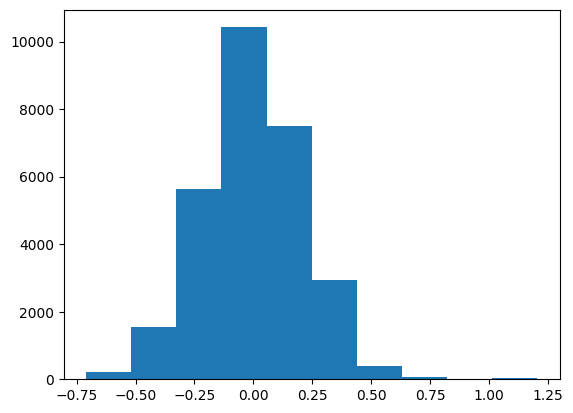

In [202]:
plt.hist(CAR['L_H_W_ratio'] - np.mean(CAR['L_H_W_ratio']))
plt.show()

In [199]:
tt = CAR['L_H_ratio'] - np.mean(CAR['L_H_ratio'])
tt[tt<-1.3]

array([], dtype=float64)

## ELAN Evaluation metrics (Dim delta, depth, alpha, Dim consistency)

In [1]:
from library.ron_utils import *
valset = [x.strip() for x in open('Elan_3d_box/ImageSets/val.txt').readlines()]
result_root = '0719'
dim_GT = list()
dim_ELAN = list()
depth_GT = list()
depth_ELAN = list()
alpha_GT = list()
alpha_ELAN = list()

for id_ in valset:
    gt_lines = [x.strip() for x in open(f'Elan_3d_box/renew_label/{id_}.txt').readlines()]
    gt_objects = [DetectedObject(line) for line in gt_lines if line.split()[0]=='Car']
    for obj in gt_objects:
        dim_GT.append(obj.dims[0])
        depth_GT.append(obj.locs[0][2])
        alpha_GT.append(obj.alphas[0])
        
    pred_lines = [x.strip() for x in open(f'{result_root}/label_2/{id_}.txt').readlines()]
    pred_objects = [DetectedObject(line) for line in pred_lines if line.split()[0]=='Car']
    for obj in pred_objects:
        dim_ELAN.append(obj.dims[0])
        depth_ELAN.append(obj.locs[0][2])
        alpha_ELAN.append(obj.alphas[0])

dim_GT = np.array(dim_GT)
dim_ELAN = np.array(dim_ELAN)
depth_GT = np.array(depth_GT)
depth_ELAN = np.array(depth_ELAN)
alpha_GT = np.array(alpha_GT)
alpha_ELAN = np.array(alpha_ELAN)

depth_diff = depth_GT-depth_ELAN
alpha_diff = alpha_GT - alpha_ELAN
dim_diff = np.mean(abs(dim_GT-dim_ELAN), axis=0)
print(f'[Depth diff] abs_mean: {abs(depth_diff).mean():.4f}')
print(f'[Alpha diff] abs_mean: {abs(alpha_diff).mean():.4f}')
print(f'[DIM diff] H:{dim_diff[0]:.4f}, W:{dim_diff[1]:.4f}, L:{dim_diff[2]:.4f}')
print('[Depth error]')
box_depth_error_calculation(depth_GT, depth_ELAN, 5)

[Depth diff] abs_mean: 4.1130
[Alpha diff] abs_mean: 0.2694
[DIM diff] H:0.1673, W:0.1275, L:0.4453
[Depth error]
num of Car: 665
	num of depth 0-10: 0 
	num of depth 10-20: 68   abs_delta mean:1.811m, Out of 5m: 3
	num of depth 20-30: 142   abs_delta mean:3.509m, Out of 5m: 40
	num of depth 30-40: 259   abs_delta mean:3.555m, Out of 5m: 63
	num of depth 40-50: 95   abs_delta mean:6.058m, Out of 5m: 39
	num of depth 50-60: 50   abs_delta mean:7.380m, Out of 5m: 25
  num of depth 60+: 51     abs_delta mean:4.872m, Out of 5m: 20
[Total] mean:4.113, std:4.405
